In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [187]:
class kohonen:

    def __init__(
        self,
        M,
        N,
        X,
        learning_rate=0.1,
        gauss_neighborhood_function=True,
        neighborhood_proximity=1.0,
        lattice="rectangular",
    ):
        self.M = M
        self.N = N
        self.learning_rate = learning_rate
        self.input_dim = X.shape[1]
        if gauss_neighborhood_function:
            self.neighborhood_function = self.gauss_neighborhood
        else:
            self.neighborhood_function = self.mexican_hat_neighborhood
        self.neighborhood_proximity = neighborhood_proximity
        self.lattice = lattice
        self.index_array = np.array(
            [
                np.arange(M).repeat(N).reshape(M, N),
                np.arange(N).repeat(M).reshape(N, M).T,
            ],
            dtype=float,
        )
        if lattice == "hexagonal":
            self.index_array[0] = self.index_array[0] * np.sqrt(3) / 2
            self.index_array[1][1::2] += 0.5

        # weights initialization
        self.weights = np.random.uniform(0, 1, (self.input_dim, M, N))
        minimum = np.min(X, axis=0)
        maximum = np.max(X, axis=0)
        for i in range(self.input_dim):
            self.weights[i] = minimum[i] + (maximum[i] - minimum[i]) * self.weights[i]

    def gauss_neighborhood(self, distance, epoch):
        return np.exp(-np.power(distance * epoch * self.neighborhood_proximity, 2))

    def mexican_hat_neighborhood(self, distance, epoch):
        return np.exp(-np.power(distance * epoch * self.neighborhood_proximity, 2)) * (
            2 - 4 * np.power(distance * epoch * self.neighborhood_proximity, 2)
        )

    def euclidean_distance(self, x, y):
        return np.linalg.norm(x - y)

    def decay(self, t, iteration_num):
        return self.learning_rate * np.exp(-t / iteration_num)

    def train(self, X, max_epochs):
        for epoch in range(max_epochs):
            X = np.random.permutation(X)
            decay_value = self.decay(epoch, max_epochs)
            for x in X:
                # finding the best matching unit (index of the neuron with the smallest distance to the input vector x)
                idx = np.argmin(np.linalg.norm(self.weights.T - x, axis=2).T)
                bmu = np.unravel_index(idx, self.weights[0].shape)

                # updating weights
                distance_on_lattice_matrix = np.linalg.norm(
                    (self.index_array.T - np.array(bmu)),
                    axis=2,
                ).T
                neighborhood = self.neighborhood_function(
                    distance_on_lattice_matrix, epoch
                )
                self.weights += decay_value * neighborhood * (x - self.weights.T).T

    def predict(self, X):
        return np.array(
            [
                [
                    np.argmin(
                        [
                            self.euclidean_distance(x, self.weights[:, i, j])
                            for i in range(self.M)
                            for j in range(self.N)
                        ]
                    )
                    for x in X
                ]
            ]
        ).T

## tests with numpy and speed 

### First loop

In [8]:
cube = pd.read_csv("./../data/kohonen/cube.csv")
cube_x = cube.drop("c", axis=1).to_numpy()
kohon = kohonen(2, 4, cube_x)
weights = kohon.weights
weights

array([[[-1.01156814,  2.66328134,  2.38491856,  0.96708048],
        [ 1.93136495,  2.71473683,  2.05809027,  0.0631648 ]],

       [[-1.56559317,  0.87695878,  3.59341698,  4.21392388],
        [ 4.05699271, -0.33768321, -0.51779918,  5.54942807]],

       [[ 2.9794021 ,  0.55741637,  1.93910687, -1.23854172],
        [ 2.7368817 , -1.32376104,  2.11437958,  0.04835879]]])

In [9]:
x = cube_x[40]
for i in range(2):
    for j in range(4):
        distance = kohon.euclidean_distance(x, weights[:, i, j])
        print(f"Distance from {i}, {j}: {distance}")

Distance from 0, 0: 3.5558179704295325
Distance from 0, 1: 2.866371117384524
Distance from 0, 2: 5.442909346943757
Distance from 0, 3: 5.560814488417281
Distance from 1, 0: 6.074152819974137
Distance from 1, 1: 2.4542857746727833
Distance from 1, 2: 2.602766244666087
Distance from 1, 3: 6.808399161649306


In [10]:
np.linalg.norm(weights.T - x, axis=2).T

array([[3.55581797, 2.86637112, 5.44290935, 5.56081449],
       [6.07415282, 2.45428577, 2.60276624, 6.80839916]])

In [11]:
idx = np.argmin(np.linalg.norm(weights.T - x, axis=2).T)
np.unravel_index(idx, weights[0].shape)

(1, 1)

#### Testing if i broke something 

In [12]:
kohon = kohonen(2, 4, cube_x)
kohon.train(cube_x, 10)
cube["predicted"] = kohon.predict(cube_x)
v_measure_score(cube["c"], cube["predicted"])

0.9184550780838783

### Getting rid of second loop

In [14]:
bmu = (0, 1)
for i in range(2):
    for j in range(4):
        distance_on_lattice = kohon.euclidean_distance(
            np.array(bmu), np.array([i, j])  # old approach change it
        )
        print(f"Distance from {i}, {j}: {distance_on_lattice}")

Distance from 0, 0: 1.0
Distance from 0, 1: 0.0
Distance from 0, 2: 1.0
Distance from 0, 3: 2.0
Distance from 1, 0: 1.4142135623730951
Distance from 1, 1: 1.0
Distance from 1, 2: 1.4142135623730951
Distance from 1, 3: 2.23606797749979


In [23]:
# create a matrix of distances from the BMU without looping
bmu = (0, 1)
np.arange(4).repeat(2).reshape(4, 2).T

array([[0, 1, 2, 3],
       [0, 1, 2, 3]])

In [25]:
np.arange(2).repeat(4).reshape(2, 4)

array([[0, 0, 0, 0],
       [1, 1, 1, 1]])

In [29]:
# create a 3d numpy array with the two above arrays
(
    np.array(
        [np.arange(4).repeat(2).reshape(4, 2).T, np.arange(2).repeat(4).reshape(2, 4)]
    ).T
    - np.array(bmu)
).T

array([[[ 0,  1,  2,  3],
        [ 0,  1,  2,  3]],

       [[-1, -1, -1, -1],
        [ 0,  0,  0,  0]]])

In [108]:
bmu = (0, 1)
M = 4
N = 5
distance_matrix = np.linalg.norm(
    (
        np.array(
            [
                np.arange(N).repeat(M).reshape(N, M).T,
                np.arange(M).repeat(N).reshape(M, N),
            ]
        ).T
        - np.flip(np.array(bmu))
    ),
    axis=2,
).T
distance_matrix

array([[1.        , 0.        , 1.        , 2.        , 3.        ],
       [1.41421356, 1.        , 1.41421356, 2.23606798, 3.16227766],
       [2.23606798, 2.        , 2.23606798, 2.82842712, 3.60555128],
       [3.16227766, 3.        , 3.16227766, 3.60555128, 4.24264069]])

In [51]:
neighborhood = kohon.gauss_neighborhood(distance_matrix, 1)
neighborhood

array([[4.53999298e-05, 6.73794700e-03, 1.35335283e-01, 3.67879441e-01,
        1.35335283e-01],
       [1.23409804e-04, 1.83156389e-02, 3.67879441e-01, 1.00000000e+00,
        3.67879441e-01],
       [4.53999298e-05, 6.73794700e-03, 1.35335283e-01, 3.67879441e-01,
        1.35335283e-01],
       [2.26032941e-06, 3.35462628e-04, 6.73794700e-03, 1.83156389e-02,
        6.73794700e-03]])

### "Last element" 

In [52]:
kohon = kohonen(M, N, cube_x)
weights = kohon.weights
x = cube_x[0]
for i in range(M):
    for j in range(N):
        print(neighborhood[i, j] * (x - weights[:, i, j]))

[-1.46541931e-04 -1.30863258e-04  8.68556351e-06]
[ 0.01387682 -0.02973736  0.01283148]
[-0.13659399 -0.50882717  0.26557336]
[-1.58064634 -1.70975568 -0.92180129]
[-0.05060342 -0.62222693  0.08767909]
[ 0.00020292 -0.0005306  -0.00025015]
[-0.06355731 -0.05002787 -0.0076145 ]
[-1.37800892 -0.64991787  0.66812845]
[-0.10809417 -0.63803726  0.18380338]
[ 0.33110226 -0.92262857 -0.24134313]
[-1.04209983e-04 -1.72888916e-04 -1.44869419e-05]
[ 0.00074171 -0.03822084  0.00768309]
[-0.32856869  0.06858943  0.07383868]
[-0.45824852 -1.33309321 -0.06224104]
[-0.51421478  0.07218714  0.14132349]
[ 4.79778955e-06  3.47770458e-06 -6.98766558e-06]
[-0.00133077 -0.00051455 -0.00024041]
[-0.01107501 -0.02463341  0.01148345]
[-0.07555434 -0.0738847  -0.05000482]
[-0.02839498  0.00412196 -0.01166701]


In [63]:
neighborhood * (x - weights.T).T

array([[[-1.46541931e-04,  1.38768155e-02, -1.36593991e-01,
         -1.58064634e+00, -5.06034162e-02],
        [ 2.02917338e-04, -6.35573053e-02, -1.37800892e+00,
         -1.08094172e-01,  3.31102260e-01],
        [-1.04209983e-04,  7.41705521e-04, -3.28568691e-01,
         -4.58248524e-01, -5.14214777e-01],
        [ 4.79778955e-06, -1.33076589e-03, -1.10750054e-02,
         -7.55543446e-02, -2.83949824e-02]],

       [[-1.30863258e-04, -2.97373589e-02, -5.08827166e-01,
         -1.70975568e+00, -6.22226927e-01],
        [-5.30603492e-04, -5.00278722e-02, -6.49917869e-01,
         -6.38037260e-01, -9.22628566e-01],
        [-1.72888916e-04, -3.82208368e-02,  6.85894254e-02,
         -1.33309321e+00,  7.21871430e-02],
        [ 3.47770458e-06, -5.14545603e-04, -2.46334072e-02,
         -7.38847040e-02,  4.12196152e-03]],

       [[ 8.68556351e-06,  1.28314758e-02,  2.65573361e-01,
         -9.21801293e-01,  8.76790892e-02],
        [-2.50150472e-04, -7.61450403e-03,  6.68128445e-01,


In [176]:
kohon = kohonen(2, 4, cube_x)
kohon.train(cube_x, 100)
cube["predicted"] = kohon.predict(cube_x)
v_measure_score(cube["c"], cube["predicted"])

0.9155834502607125

## Actual KOH2

In [199]:
def plot_lattice_grid(network):
    plt.figure(figsize=(10, 10))
    for i in range(network.M):
        for j in range(network.N):
            plt.plot(network.index_array[1, i, j], network.index_array[0, i, j], "bo")

            if i > 0:
                plt.plot(
                    [network.index_array[1, i, j], network.index_array[1, i - 1, j]],
                    [network.index_array[0, i, j], network.index_array[0, i - 1, j]],
                    "k--",
                )
            if j > 0:
                plt.plot(
                    [network.index_array[1, i, j], network.index_array[1, i, j - 1]],
                    [network.index_array[0, i, j], network.index_array[0, i, j - 1]],
                    "k--",
                )
            if network.lattice == "hexagonal":
                if i % 2 == 0 and j > 0 and i > 0:
                    plt.plot(
                        [
                            network.index_array[1, i, j],
                            network.index_array[1, i - 1, j - 1],
                        ],
                        [
                            network.index_array[0, i, j],
                            network.index_array[0, i - 1, j - 1],
                        ],
                        "k--",
                    )
                elif i % 2 == 1 and j < network.N - 1:
                    plt.plot(
                        [
                            network.index_array[1, i, j],
                            network.index_array[1, i - 1, j + 1],
                        ],
                        [
                            network.index_array[0, i, j],
                            network.index_array[0, i - 1, j + 1],
                        ],
                        "k--",
                    )
    plt.title("Network lattice grid")

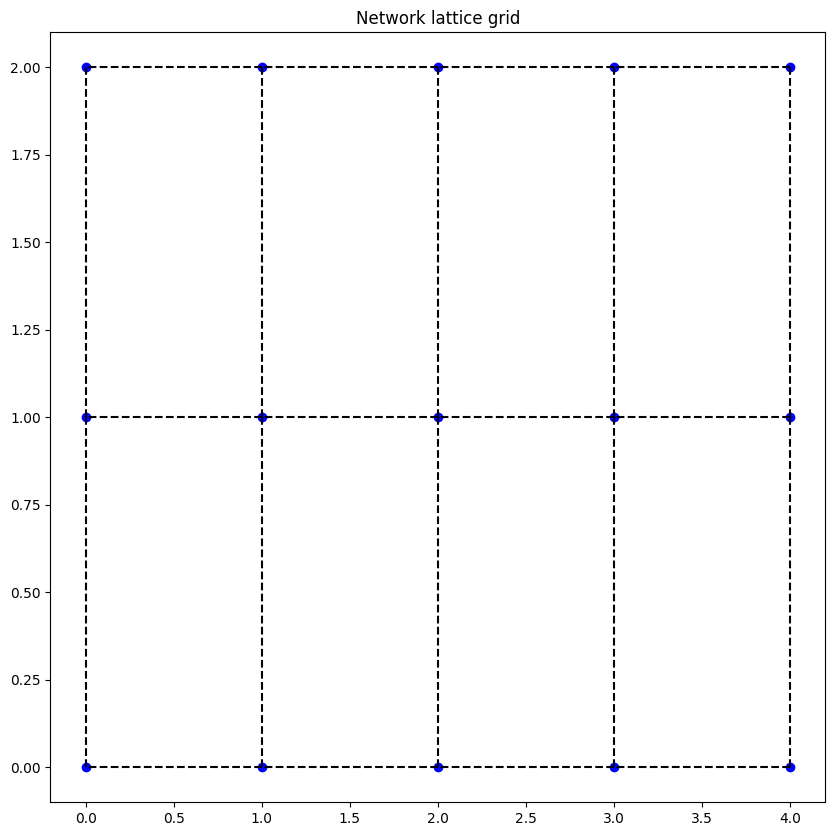

In [161]:
kochon = kohonen(3, 5, cube_x)
plot_lattice_grid(kochon)

In [185]:
M = 5
N = 4
index_array = np.array(
    [
        np.arange(M).repeat(N).reshape(M, N),
        np.arange(N).repeat(M).reshape(N, M).T,
    ],
    dtype=float,
)
index_array[0] = index_array[0] * np.sqrt(3) / 2
index_array[1][1::2] += 0.5
index_array

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.8660254 , 0.8660254 , 0.8660254 , 0.8660254 ],
        [1.73205081, 1.73205081, 1.73205081, 1.73205081],
        [2.59807621, 2.59807621, 2.59807621, 2.59807621],
        [3.46410162, 3.46410162, 3.46410162, 3.46410162]],

       [[0.        , 1.        , 2.        , 3.        ],
        [0.5       , 1.5       , 2.5       , 3.5       ],
        [0.        , 1.        , 2.        , 3.        ],
        [0.5       , 1.5       , 2.5       , 3.5       ],
        [0.        , 1.        , 2.        , 3.        ]]])

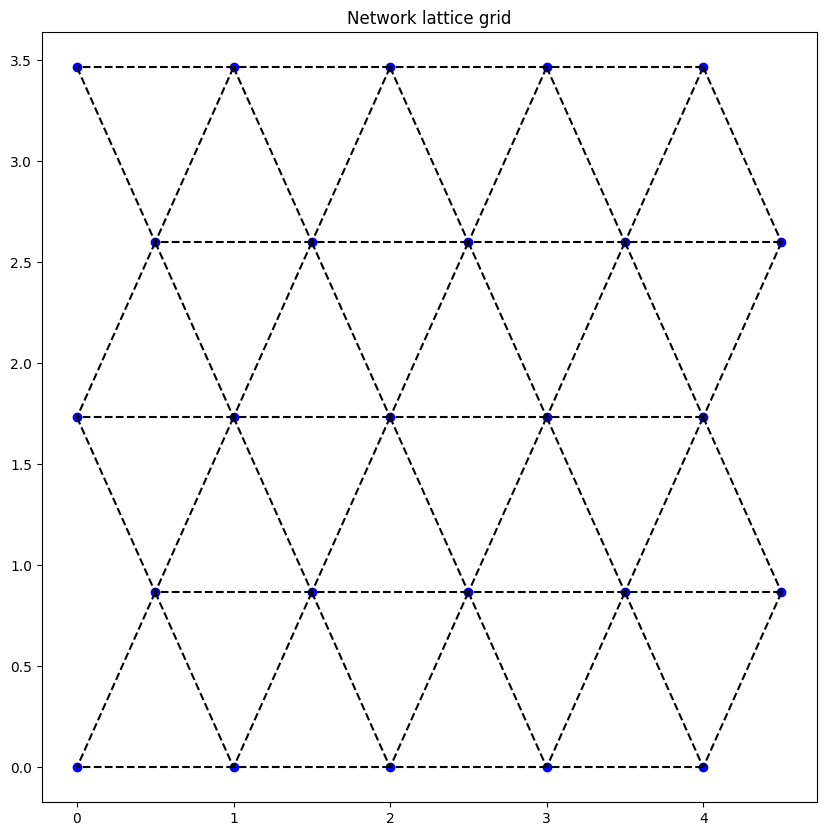

In [200]:
kochon = kohonen(5, 5, cube_x, lattice="hexagonal")
plot_lattice_grid(kochon)